In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from glob import glob
import h5py as h5
import yaml
from yaml import Loader
from glob import glob
import os
plt.rcParams['figure.figsize']        = 10., 10.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 14
plt.rcParams['axes.titlesize']        = 14
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 14
plt.rcParams['ytick.labelsize']       = 14
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 14


In [60]:
from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from scipy.interpolate import interp1d
from itertools import product
import sys
sys.path.append('/global/homes/j/jderose/project/ZeNBu/')
from zenbu import Zenbu 

def _lpt_pk(k, p_lin, D=None, cleftobj=None, kecleft=False, zenbu=True, cutoff=np.pi*700/525.):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    elif zenbu:
        zobj = Zenbu(k, p_lin, cutoff=cutoff, N=2700, jn=15)
        zobj.make_ptable()
        cleftpk = zobj.pktable.T
        

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    if not zenbu:
        cleftpk[2, :] /= 2
        cleftpk[6, :] /= 0.25
        cleftpk[7, :] /= 2
        cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')

    return cleftspline, cleftobj


def _cleft_pk(k, p_lin, D=None, cleftobj=None, kecleft=True):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')

    return cleftspline, cleftobj

def load_pk_from_dict(filename):
    
    pk_ij_list = np.load(filename, allow_pickle=True)
    nspec = len(pk_ij_list)
    keys = list(pk_ij_list[0].keys())
    k = pk_ij_list[0]['k']
    nk = k.shape[0]
    
    if 'mu' in keys:
        mu = pk_ij_list[0]['mu']  
        nmu = mu.shape[-1]
    else:
        nmu = 1
        mu = None
    
    if 'power_poles' in keys:
        npoles = pk_ij_list[0]['power_poles'].shape[0]
        has_poles = True
        pk_pole_array = np.zeros((nspec, npoles, nk))
        
    else:
        npoles = 1
        has_poles = False
        
        
    pk_wedge_array = np.zeros((nspec, nk, nmu))
        
    for i in range(nspec):
        #power_wedges is always defined, even if only using 1d pk (then wedge is [0,1])
        pk_wedges = pk_ij_list[i]['power_wedges']
        pk_wedge_array[i,...] = pk_wedges.reshape(nk,-1)
        
        if has_poles:
            pk_poles = pk_ij_list[i]['power_poles']
            pk_pole_array[i,...] = pk_poles
            
    if has_poles:
        return k, mu, pk_wedge_array, pk_pole_array
    else:
        return k, mu, pk_wedge_array
    
def get_spectra_from_fields(fields1, fields2, neutrinos=True):
    spectra = []
    for i, fi in enumerate(fields1):
        for j, fj in enumerate(fields2):
            if (i<j) | (neutrinos & (i==1) & (j==0)): continue
            spectra.append((fi, fj))
                      
    return spectra
                      
def compute_beta_and_reduce_variance(k, pk_ij_nn, pk_ij_zn, pk_ij_zz, pk_ij_zenbu, 
                                     neutrinos=True, k0=0.618, dk=0.167):
    
    if neutrinos:
        fields_n = ['1m', '1cb', 'd', 'd2', 's', 'n2']
        component_spectra_nn = get_spectra_from_fields(fields_n, fields_n)
        nspec_nn = len(component_spectra_nn)
        pk_ij_nn_dict = dict(zip(component_spectra_nn, pk_ij_nn))
    else:
        fields_n = ['1cb', 'd', 'd2', 's', 'n2']
        component_spectra_nn = get_spectra_from_fields(fields_n, fields_n, neutrinos=False)
        nspec_nn = len(component_spectra_nn)
        pk_ij_nn_dict = dict(zip(component_spectra_nn, pk_ij_nn))

    fields_z = ['1', 'd', 'd2', 's', 'n2']
    fields_zenbu = ['1', 'd', 'd2', 's']

    component_spectra_zz = get_spectra_from_fields(fields_z, fields_z, neutrinos=False)
    component_spectra_zenbu = get_spectra_from_fields(fields_z, fields_zenbu, neutrinos=False)
    
    pk_ij_zz_dict = dict(zip(component_spectra_zz, pk_ij_zz))
    pk_ij_zenbu_dict = dict(zip(component_spectra_zenbu, pk_ij_zenbu))
    
    component_spectra_zn = list(product(fields_z, fields_n))
    pk_ij_zn_dict = dict(zip(component_spectra_zn, pk_ij_zn))
    
    beta_ij = []
    beta_ij_damp = []
    pk_ij_nn_hat = []
    pk_ij_zz_l = []
    pk_ij_zenbu_l = []
    pk_ij_zn_l = []
    pk_ij_nz_l = []
    for n in range(nspec_nn):
        if (component_spectra_nn[n][0] == 'n2') | (component_spectra_nn[n][1] == 'n2'): continue
        
        f_i_n = component_spectra_nn[n][0]
        f_i_z = component_spectra_nn[n][0]
        f_j_n = component_spectra_nn[n][1]
        f_j_z = component_spectra_nn[n][1]
        
        if f_i_n[0] == '1':
            f_i_z = '1'
        if f_j_n[0] == '1':
            f_j_z = '1'
        
        p_ii_zn = pk_ij_zn_dict[(f_i_z, f_i_n)]
        p_jj_zn = pk_ij_zn_dict[(f_j_z, f_j_n)]
        p_ij_zn = pk_ij_zn_dict[(f_i_z, f_j_n)]
        p_ij_nz = pk_ij_zn_dict[(f_j_z, f_i_n)]
        
        try:
            p_ii_zz = pk_ij_zz_dict[(f_i_z, f_i_z)]
            p_jj_zz = pk_ij_zz_dict[(f_j_z, f_j_z)]
            p_ij_zz = pk_ij_zz_dict[(f_j_z, f_i_z)]
            p_ij_zenbu = pk_ij_zenbu_dict[(f_j_z, f_i_z)]
        except:
            p_ii_zz = pk_ij_zz_dict[(f_i_z, f_i_z)]
            p_jj_zz = pk_ij_zz_dict[(f_j_z, f_j_z)]
            p_ij_zz = pk_ij_zz_dict[(f_i_z, f_j_z)]
            p_ij_zenbu = pk_ij_zenbu_dict[(f_i_z, f_j_z)]            
        
        beta = (p_ii_zn * p_jj_zn + p_ij_zn * p_ij_nz) / (p_ij_zz**2 + p_ii_zz*p_jj_zz)
        beta_damp = 1/2 * (1 - np.tanh((k - k0)/dk)) * beta
        
        beta_ij.append(beta)
        beta_ij_damp.append(beta_damp)
        
        p_ij_nn_hat = pk_ij_nn[n] - beta_damp * (p_ij_zz - p_ij_zenbu)

        pk_ij_nn_hat.append(p_ij_nn_hat)
        pk_ij_zz_l.append(p_ij_zz)
        pk_ij_zenbu_l.append(p_ij_zenbu)
        pk_ij_zn_l.append(p_ij_zn)
        pk_ij_nz_l.append(p_ij_nz)
        
        
    return pk_ij_nn_hat, beta_ij, beta_ij_damp, pk_ij_zz_l, pk_ij_zenbu_l, pk_ij_zn_l, pk_ij_nz_l

def lpt_spectra(k, z, anzu_config, kin, p_lin_in, pkclass=None):

    if pkclass==None:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)
        pkclass = Class()
        pkclass.set(cfg["Cosmology"])
        pkclass.compute()

    cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
    kt = np.logspace(-4,1.2,500)

    pk_cb_lin = np.array([pkclass.pk_cb_lin(ki, np.array([0])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])
    pk_m_lin = np.array([pkclass.pk_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])
    pk_cb_lin_zb = np.array([pkclass.pk_cb_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])

    Dthis = pkclass.scale_independent_growth_factor(z)
    Dic = pkclass.scale_independent_growth_factor(cfg['z_ic'])
    plin = np.exp(interp1d(np.log(kin), np.log(p_lin_in), fill_value='extrapolate')(np.log(kt))) * np.exp(-kt**2/(cutoff**2))
#    plin = np.exp(interp1d(np.log(kin), np.log(p_lin_in), fill_value='extrapolate')(np.log(kt)))

    zbspline, cleftobj = _lpt_pk(kt, plin*(Dthis/Dic)**2, cutoff=10)

    cleft_m_spline, cleftobj = _cleft_pk(kt, pk_m_lin, kecleft=False)
    cleft_cb_spline, cleftobj = _cleft_pk(kt, pk_cb_lin_zb, kecleft=False)

    pk_zenbu = zbspline(k)
    pk_cb_3lpt = cleft_cb_spline(k)
    pk_m_3lpt = cleft_m_spline(k)

    return pk_zenbu[1:], pk_m_3lpt[1:12], pk_cb_3lpt[1:12], pkclass

        
def reduce_variance(k, pk_ij_nn, pk_ij_zn, pk_ij_zz, anzu_config, z, kt, p_lin_in, neutrinos=True, pkclass=None):

    pk_ij_zenbu, pk_m_3lpt, pk_cb_3lpt, pkclass = lpt_spectra(k, z, anzu_config, kt, p_lin_in, pkclass=pkclass)
    pk_ij_nn_hat, beta_ij, beta_ij_damp, pk_ij_zz_l, pk_ij_zenbu_l, pk_ij_zn_l, pk_ij_nz_l = compute_beta_and_reduce_variance(k, pk_ij_nn, pk_ij_zn, pk_ij_zz, pk_ij_zenbu, neutrinos=neutrinos, k0=0.618, dk=0.167)    

    return pk_ij_nn_hat, beta_ij, beta_ij_damp, pk_ij_zz_l, pk_ij_zenbu_l, pk_ij_zn_l, pk_ij_nz_l, pk_m_3lpt, pk_cb_3lpt, pkclass

In [61]:
z_all = np.array([3.        , 2.81388253, 2.6350418 , 2.46500347, 2.30360093,
       2.1496063 , 2.003003  , 1.86204923, 1.72851296, 1.60145682,
       1.48015873, 1.36406619, 1.25377507, 1.1486893 , 1.04834084,
       0.9527436 , 0.8615041 , 0.77462289, 0.69176112, 0.61290323,
       0.53751538, 0.46584579, 0.39742873, 0.33226752, 0.27000254,
       0.21065375, 0.15420129, 0.10035211, 0.04898773, 0.        ])
a_all = 1/(1 + z_all)


In [62]:
boxnums = [23,24,25,26,27,28,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,46,47,48,49]
#boxnums = [23,24,30]
#boxnums=[23,24,30]

In [63]:
pk_ij_hat = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_3lpt = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zenbu = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zz_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_nn_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zn_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_nz_all = np.zeros((len(boxnums), len(a_all), 14, 699))
beta_ij_all = np.zeros((len(boxnums), len(a_all), 14, 699))


In [64]:
pk_ij_hat = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_3lpt = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zenbu = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zz_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_nn_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_zn_all = np.zeros((len(boxnums), len(a_all), 14, 699))
pk_ij_nz_all = np.zeros((len(boxnums), len(a_all), 14, 699))
beta_ij_all = np.zeros((len(boxnums), len(a_all), 14, 699))


for i, boxnum in enumerate(boxnums[:1]):
    print(boxnum)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box{}_1400/anzu_fields/'.format(boxnum)
    configbase = '/pscratch/sd/j/jderose/aemulus_nu_setup/Box{}_1400/run/'.format(boxnum)
    anzu_config = configbase + 'anzu_fields.param'
    

    anzu_config = configbase + 'anzu_fields.param'

    s_m_map = {0:0, 2:1, 5:3, 9:6}
    s_cb_map = {1:0, 3:1, 4:2, 6:3, 7:4, 8:5, 10:6, 11:7, 12:8, 13:9}

    for j, a_this in enumerate(np.array(a_all[:1])):
        pk_zz_fname = basename + 'basis_spectra_za_surrogate_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
        pk_nn_fname = basename + 'basis_spectra_nbody_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
        pk_zn_fname = basename + 'basis_spectra_za_surrogate_crosscorr_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
        z_this = 1/a_this - 1
        k, mu, pk_ij_nn, pk_ij_nn_poles = load_pk_from_dict(pk_nn_fname)
        k, mu, pk_ij_zn, _ = load_pk_from_dict(pk_zn_fname)
        k, mu, pk_ij_zz, _ = load_pk_from_dict(pk_zz_fname)
        p_in = np.loadtxt('{}/input_powerspec.txt'.format(configbase))
        pk_ij_nn_hat, beta_ij, beta_ij_damp, pk_ij_zz_l, pk_ij_zenbu_l, pk_ij_zn_l, pk_ij_nz_l, pk_m_3lpt, pk_cb_3lpt, pkclass = reduce_variance(k, pk_ij_nn[...,0], pk_ij_zn[...,0],
                                                                                                                                                 pk_ij_zz[...,0], anzu_config, z_this, p_in[:,0], p_in[:,2]*(2*np.pi)**3)

        for s in np.arange(len(pk_ij_nn_hat)):
            pk_ij_hat[i, j, s, :] = pk_ij_nn_hat[s]
            pk_ij_zenbu[i, j, s, :] = pk_ij_zenbu_l[s]
            pk_ij_zz_all[i, j, s, :] = pk_ij_zz_l[s]
            pk_ij_nn_all[i, j, s, :] = pk_ij_nn[s,...,0]
            pk_ij_zn_all[i, j, s, :] = pk_ij_zn_l[s]
            pk_ij_nz_all[i, j, s, :] = pk_ij_nz_l[s]
            beta_ij_all[i, j, s, :] = beta_ij[s]

            if s in [0, 2, 5, 9]:
                pk_ij_3lpt[i, j, s, :] = pk_m_3lpt[s_m_map[s]]
            else:
                pk_ij_3lpt[i, j, s, :] = pk_cb_3lpt[s_cb_map[s]]

23


/tmp/ipykernel_95587/4289257672.py:27: RuntimeWarning: invalid value encountered in true_divide
  ax[i,j].semilogx(k, pk_ij_zz_all[bn,zi,counter,:].T/pk_ij_zenbu[bn,zi,counter,:].T-1)


(0.01, 1)

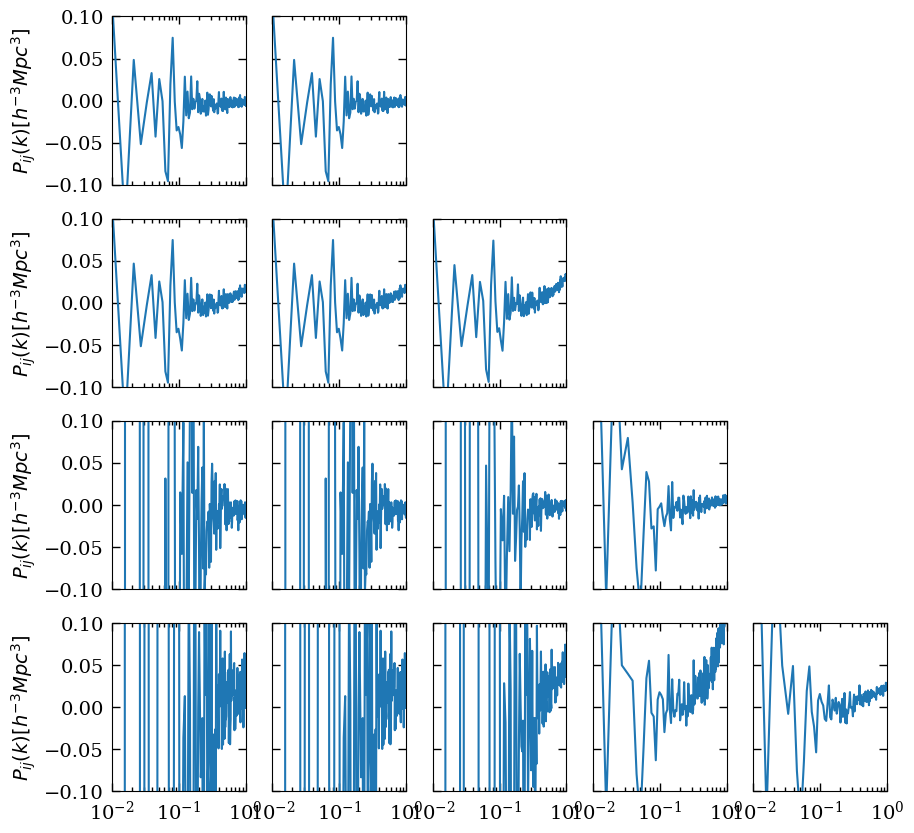

In [65]:
f, ax = plt.subplots(4,5, sharex=True, sharey=True)
counter = 0
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']
i=0
j=0
lptcounter = 0
for ii in range(6):
    for jj in range(6):
        if (ii==0) & (jj==0):
            i=0
            j=0
        else:
            i = ii-1
            j = jj        
        if ((i>3) | (j>4)) | ((ii==1) & (jj==0)): continue
        if (j>i+1):
            if i==-1: i=0
            if (i==0) & (j==1):
                continue
            else:
                ax[i,j].axis('off')
                continue
            
        bn=0
        zi = 0
        for bn in range(len(boxnums)-1):
            ax[i,j].semilogx(k, pk_ij_zz_all[bn,zi,counter,:].T/pk_ij_zenbu[bn,zi,counter,:].T-1)

        counter +=1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} Mpc]$')
        if j==0:
            ax[i,j].set_ylabel(r'$P_{ij}(k) [h^{-3} Mpc^3]$')         
            
ax[0,0].set_ylim([-0.1,0.1])
ax[0,0].set_xlim([0.01, 1])
#ax[0,0].legend()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


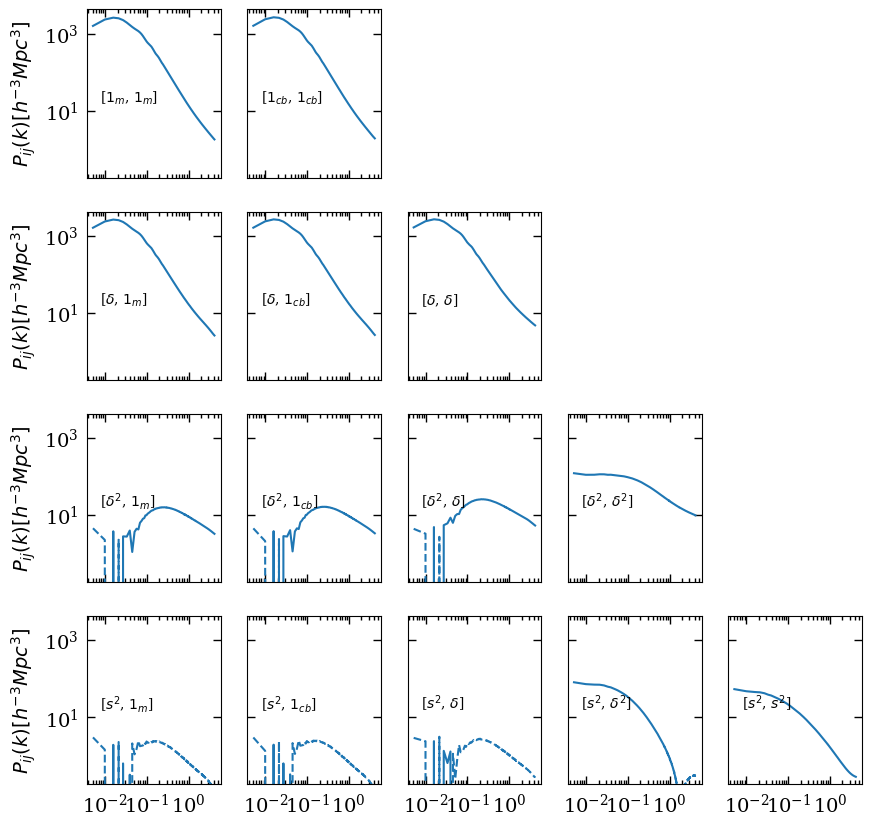

In [14]:
f, ax = plt.subplots(4,5, sharex=True, sharey=True)
counter = 0
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']
i=0
j=0
zi = 1
lptcounter = 0
for ii in range(6):
    for jj in range(6):
        if (ii==0) & (jj==0):
            i=0
            j=0
        else:
            i = ii-1
            j = jj        
        if ((i>3) | (j>4)) | ((ii==1) & (jj==0)): continue
        if (j>i+1):
            if i==-1: i=0
            if (i==0) & (j==1):
                continue
            else:
                ax[i,j].axis('off')
                continue
            

        ax[i,j].loglog(k, pk_ij_hat[:,zi,counter,:].T)
        ax[i,j].set_prop_cycle(None)
        ax[i,j].loglog(k, -pk_ij_hat[:,zi,counter,:].T, ls='--')

        ax[i,j].text(0.1, 0.45, r'[{}, {}]'.format(fields[ii], fields[jj]), fontsize=10, transform=ax[i,j].transAxes)
        counter +=1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} Mpc]$')
        if j==0:
            ax[i,j].set_ylabel(r'$P_{ij}(k) [h^{-3} Mpc^3]$')         

/tmp/ipykernel_95587/3957387592.py:28: RuntimeWarning: invalid value encountered in true_divide
  ax[i,j].semilogx(k, pk_ij_hat[bn,zi,counter,:].T/pk_ij_3lpt[bn,zi,counter,:].T-1, label='nnh/3lpt')


(0.005, 3.0)

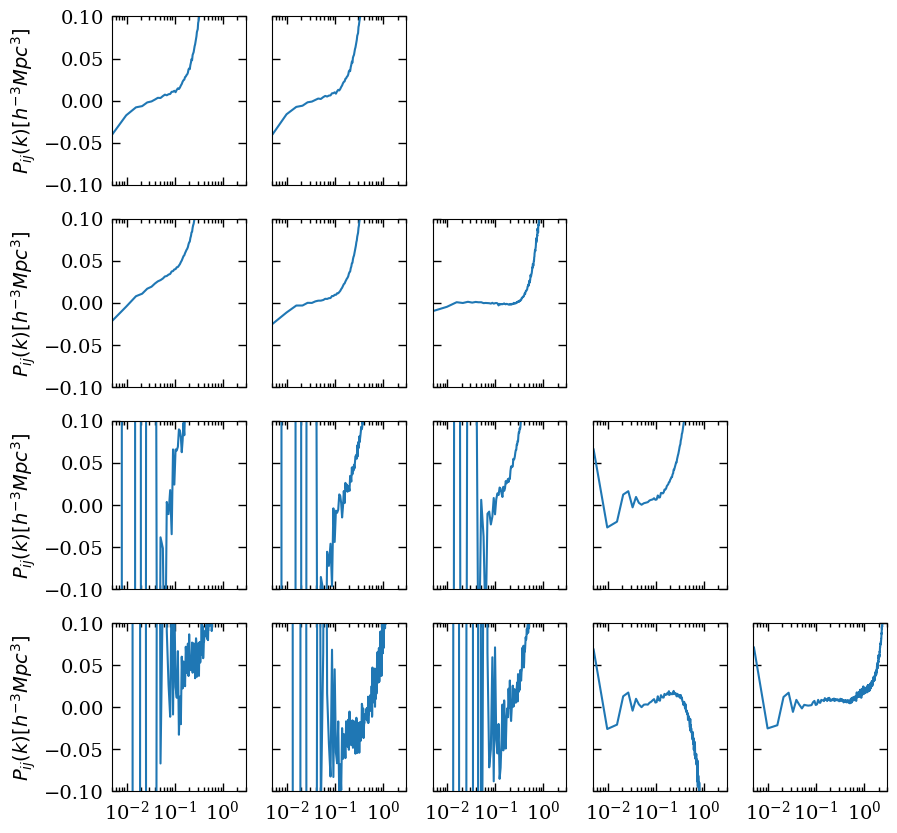

In [15]:
f, ax = plt.subplots(4,5, sharex=True, sharey=True)
counter = 0
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']
i=0
j=0
lptcounter = 0
for ii in range(6):
    for jj in range(6):
        if (ii==0) & (jj==0):
            i=0
            j=0
        else:
            i = ii-1
            j = jj        
        if ((i>3) | (j>4)) | ((ii==1) & (jj==0)): continue
        if (j>i+1):
            if i==-1: i=0
            if (i==0) & (j==1):
                continue
            else:
                ax[i,j].axis('off')
                continue
            
        bn=0
        zi = 0
        for bn in range(len(boxnums)-1):
            ax[i,j].semilogx(k, pk_ij_hat[bn,zi,counter,:].T/pk_ij_3lpt[bn,zi,counter,:].T-1, label='nnh/3lpt')

        counter +=1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} Mpc]$')
        if j==0:
            ax[i,j].set_ylabel(r'$P_{ij}(k) [h^{-3} Mpc^3]$')         
            
ax[0,0].set_ylim([-0.1,0.1])
ax[0,0].set_xlim([5e-3, 3.0])
#ax[0,0].legend()

/tmp/ipykernel_95587/1333891312.py:27: RuntimeWarning: invalid value encountered in true_divide
  ax[i,j].semilogx(k, pk_ij_zz_all[bn,zi,counter,:].T/pk_ij_zenbu[bn,zi,counter,:].T-1)


(0.005, 3.0)

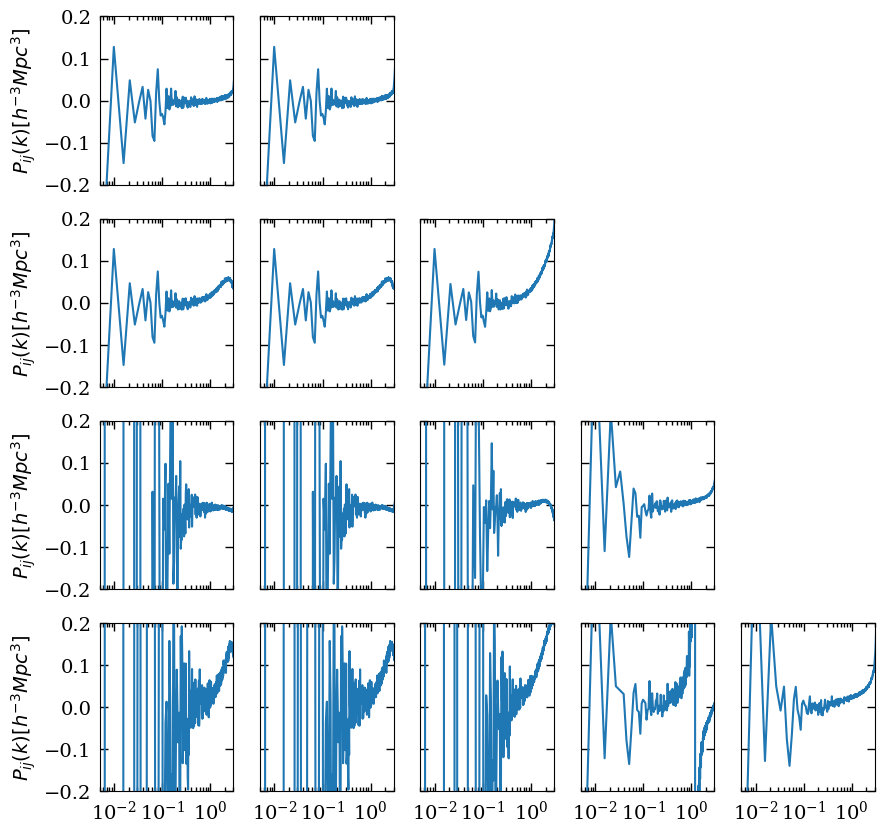

(0.005, 3.0)

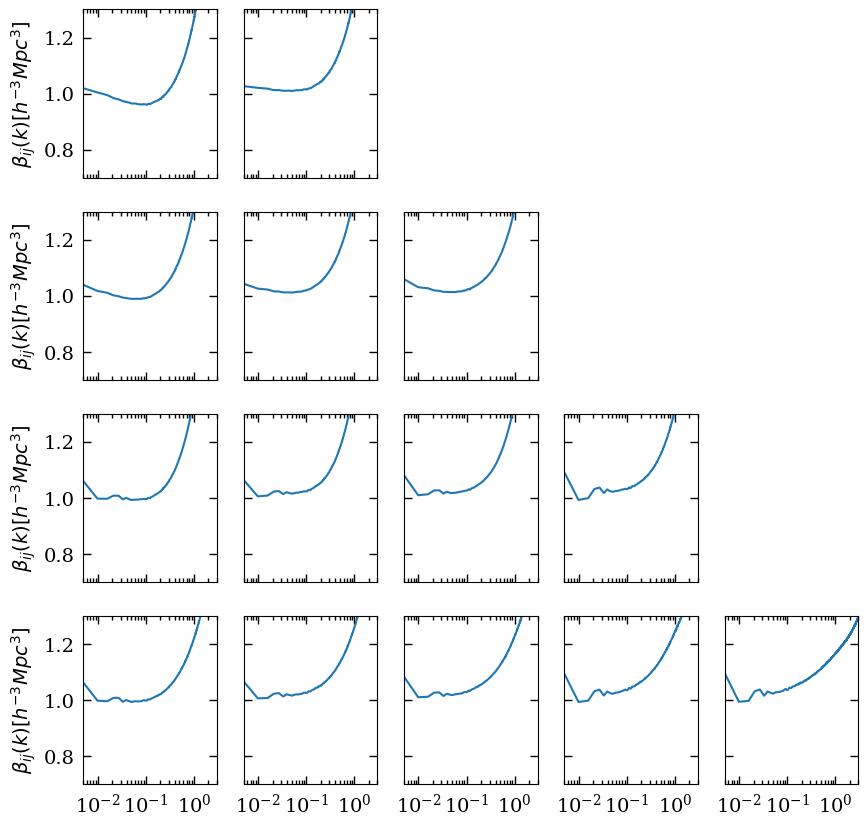

In [16]:
f, ax = plt.subplots(4,5, sharex=True, sharey=True)
counter = 0
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']
i=0
j=0
lptcounter = 0
for ii in range(6):
    for jj in range(6):
        if (ii==0) & (jj==0):
            i=0
            j=0
        else:
            i = ii-1
            j = jj        
        if ((i>3) | (j>4)) | ((ii==1) & (jj==0)): continue
        if (j>i+1):
            if i==-1: i=0
            if (i==0) & (j==1):
                continue
            else:
                ax[i,j].axis('off')
                continue
            
        bn=0
        zi = 1
        for bn in range(len(boxnums)-1):
            ax[i,j].semilogx(k, beta_ij_all[bn,zi,counter,:])

        counter +=1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} Mpc]$')
        if j==0:
            ax[i,j].set_ylabel(r'$\beta_{ij}(k) [h^{-3} Mpc^3]$')         
            
ax[0,0].set_ylim([0.7,1.3])
ax[0,0].set_xlim([5e-3, 3.0])
#ax[0,0].legend()